# Make a simple FeedForward network for the bus data

## Initialization

In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss
from torch.optim import Adam, lr_scheduler
import numpy as np

## Import data using the MoviaBusDataset

In [2]:
previous_timesteps = 6
prediction_steps = 3
batch_size = 25
num_epochs = 100

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=previous_timesteps, max_future_time_steps=prediction_steps, timeofday = True)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=previous_timesteps, max_future_time_steps=prediction_steps, timeofday = True)

train.normalize()
test.normalize(train.mean, train.std)

## The Model

In [3]:
class FNN(BaseNetwork):
    def __init__(self, num_hidden):
        super().__init__()
        

        self.FNN = Sequential(
            Linear(previous_timesteps+1, num_hidden),
            ReLU(),
            Linear(num_hidden, num_hidden),
            ReLU(),
            Linear(num_hidden, 1),
        )

    def forward(self,x):
        """
        x : [batch_size, prev_timesteps, num_roads]
        
        """
        #Transpose input, such that the previous time steps are the last dimension
        x = x.transpose(2,1)

        predictions = []
        for _ in range(self.max_timestep):
            #Run the input through the network
            prediction = self.FNN(x).squeeze()

            #Append the prediction to the list of predictions. 
            #If the data includes timeofday, this shouldn't be included
            predictions.append(prediction[:,:self.num_roads])

            #remove oldest timestep
            x = x[:,:,1:]
            #unsqueeze output so its size is [batch_size, num_roads, timesteps]
            prediction = prediction.unsqueeze(2)

            #append the new prediction to the input
            x = torch.cat((x,prediction),dim=2)


        return torch.stack(predictions,1)

net = FNN(num_hidden=100)

optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=1e-4)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

## Training the network

In [4]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  scheduler_fun=scheduler_fun,
                  criterion=criterion)

epoch =  0  train loss = 0.752   test loss = 0.744   output_std = 0.347
epoch =  2  train loss = 0.702   test loss = 0.708   output_std = 0.402
epoch =  4  train loss = 0.693   test loss = 0.703   output_std = 0.405
epoch =  6  train loss = 0.690   test loss = 0.699   output_std = 0.424
epoch =  8  train loss = 0.689   test loss = 0.701   output_std = 0.419
epoch = 10  train loss = 0.688   test loss = 0.699   output_std = 0.389
epoch = 12  train loss = 0.680   test loss = 0.695   output_std = 0.410
epoch = 14  train loss = 0.680   test loss = 0.695   output_std = 0.412
epoch = 16  train loss = 0.679   test loss = 0.694   output_std = 0.414
epoch = 18  train loss = 0.679   test loss = 0.694   output_std = 0.416
epoch = 20  train loss = 0.679   test loss = 0.694   output_std = 0.417
epoch = 22  train loss = 0.677   test loss = 0.693   output_std = 0.433
epoch = 24  train loss = 0.677   test loss = 0.693   output_std = 0.433
epoch = 26  train loss = 0.677   test loss = 0.693   output_std 

## Evaluate the network on a test dataset 

In [13]:
net.get_MAE_score(timestep=1)

1.3587682247161865

### Example of modelled data vs real data for one road segment 

<IPython.core.display.Javascript object>


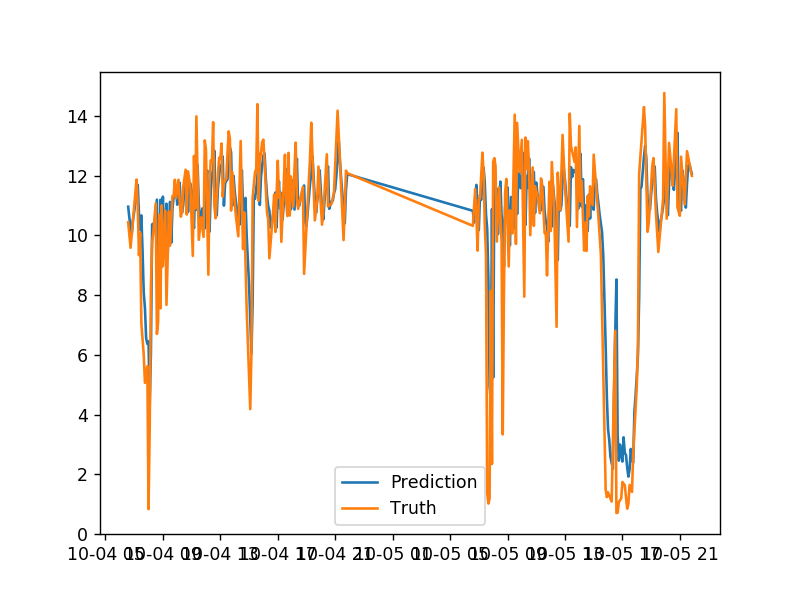

In [16]:
%matplotlib notebook

net.visualize_road(timesteps=1, road=23)